# Курсовой проект по курсу библиотеки Python для DataScience
## Группа: GU_BigData_1652 
## Студент: Ваганова Юлия

### Задание для курсового проекта

Метрика:
R2 - коэффициент детерминации (sklearn.metrics.r2_score)

Сдача проекта:
1. Сдать проект нужно в течение 7 дней после окончания последнего вебинара.
2. Прислать в раздел Задания Урока 10 ("Вебинар. Консультация по итоговому проекту") ссылку на ноутбук в github или public kaggle notebook.
3. Необходимо получить R2 > 0.6 на Private Leaderboard.
4. Укажите свой ник на kaggle 


Примечание:
Все файлы csv должны содержать названия полей (header - то есть "шапку"),разделитель - запятая. В файлах не должны содержаться индексы из датафрейма.
____________
Рекомендации для файла с кодом (ipynb):
1. Файл должен содержать заголовки и комментарии
2. Повторяющиеся операции лучше оформлять в виде функций
3. По возможности добавлять графики, описывающие данные (около 3-5)
4. Добавлять только лучшую модель, то есть не включать в код все варианты решения проекта
5. Скрипт проекта должен отрабатывать от начала и до конца (от загрузки данных до выгрузки предсказаний)
6. Весь проект должен быть в одном скрипте (файл ipynb).
7. При использовании статистик (среднее, медиана и т.д.) в качестве признаков, лучше считать их на трейне, и потом на валидационных и тестовых данных не считать статистики заново, а брать их с трейна.
8. Проект должен полностью отрабатывать за разумное время (не больше 10 минут), поэтому в финальный вариант лучше не включать GridSearch с перебором большого количества сочетаний параметров. 

### Подключение библиотек и скриптов

In [132]:
import os
os.chdir('C:\\Users\\julia\\Documents\\Мои документы\\GB\\Python Libs\\Курсовой проект\\')


In [133]:
import numpy as np
import pandas as pd
import random

from sklearn.model_selection import train_test_split, cross_val_score, KFold, GridSearchCV
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import r2_score as r2
from sklearn.decomposition import PCA
from datetime import datetime

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

matplotlib.rcParams.update({'font.size': 14})

In [134]:
def evaluate_preds(train_true_values, train_pred_values, test_true_values, test_pred_values):
    print("Train R2:\t" + str(round(r2(train_true_values, train_pred_values), 3)))
    print("Test R2:\t" + str(round(r2(test_true_values, test_pred_values), 3)))
    
    plt.figure(figsize=(18,10))
    
    plt.subplot(121)
    sns.scatterplot(x=train_pred_values, y=train_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Train sample prediction')
    
    plt.subplot(122)
    sns.scatterplot(x=test_pred_values, y=test_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Test sample prediction')

    plt.show()

### Пути к директориям и файлам

In [135]:
TRAIN_DATASET_PATH = 'train.csv'
TEST_DATASET_PATH = 'test.csv'

### Загрузка данных <a class='anchor' id='load'>

**Описание датасета**

* **Id** - идентификационный номер квартиры
* **DistrictId** - идентификационный номер района
* **Rooms** - количество комнат
* **Square** - площадь
* **LifeSquare** - жилая площадь
* **KitchenSquare** - площадь кухни
* **Floor** - этаж
* **HouseFloor** - количество этажей в доме
* **HouseYear** - год постройки дома
* **Ecology_1, Ecology_2, Ecology_3** - экологические показатели местности
* **Social_1, Social_2, Social_3** - социальные показатели местности
* **Healthcare_1, Helthcare_2** - показатели местности, связанные с охраной здоровья
* **Shops_1, Shops_2** - показатели, связанные с наличием магазинов, торговых центров
* **Price** - цена квартиры

In [136]:
df_train = pd.read_csv(TRAIN_DATASET_PATH)
df_train.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
0,11809,27,3.0,115.027311,NaN,10.0,4,10.0,2014,0.075424,B,B,11,3097,0,NaN,0,0,B,305018.871089
1,3013,22,1.0,39.832524,23.169223,8.0,7,8.0,1966,0.118537,B,B,30,6207,1,1183.0,1,0,B,177734.553407
2,8215,1,3.0,78.342215,47.671972,10.0,2,17.0,1988,0.025609,B,B,33,5261,0,240.0,3,1,B,282078.720850
3,2352,1,1.0,40.409907,NaN,1.0,10,22.0,1977,0.007122,B,B,1,264,0,NaN,0,1,B,168106.007630
4,13866,94,2.0,64.285067,38.562517,9.0,16,16.0,1972,0.282798,B,B,33,8667,2,NaN,0,6,B,343995.102962


In [137]:
df_test = pd.read_csv(TEST_DATASET_PATH)
df_test.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
0,4567,44,1.0,36.847630,19.094182,5.0,5,9.0,1970,0.036122,B,B,24,4378,0,1036.0,1,1,B
1,5925,62,1.0,42.493907,42.568133,10.0,7,17.0,2017,0.072158,B,B,2,629,1,NaN,0,0,A
2,960,27,2.0,59.463678,NaN,9.0,19,19.0,1977,0.211401,B,B,9,1892,0,NaN,0,1,B
3,3848,23,3.0,49.646030,33.893825,6.0,2,2.0,1965,0.014073,B,B,2,475,0,NaN,0,0,B
4,746,74,1.0,53.837056,NaN,1.0,8,17.0,1977,0.309479,B,B,35,7715,4,990.0,0,6,B


In [138]:
print('Строк в трейне:', df_train.shape[0])
print('Строк в тесте', df_test.shape[0])

Строк в трейне: 10000
Строк в тесте 5000


In [139]:
df_train.shape[1] - 1 == df_test.shape[1]

True

In [140]:
df_train.dtypes

Id                 int64
DistrictId         int64
Rooms            float64
Square           float64
LifeSquare       float64
KitchenSquare    float64
Floor              int64
HouseFloor       float64
HouseYear          int64
Ecology_1        float64
Ecology_2         object
Ecology_3         object
Social_1           int64
Social_2           int64
Social_3           int64
Healthcare_1     float64
Helthcare_2        int64
Shops_1            int64
Shops_2           object
Price            float64
dtype: object

### Приведение типов

In [141]:
# Уберем id из вещественных признаков. DistrictId оставим, так как от района может зависеть цена.
df_train['Id'] = df_train['Id'].astype(str)

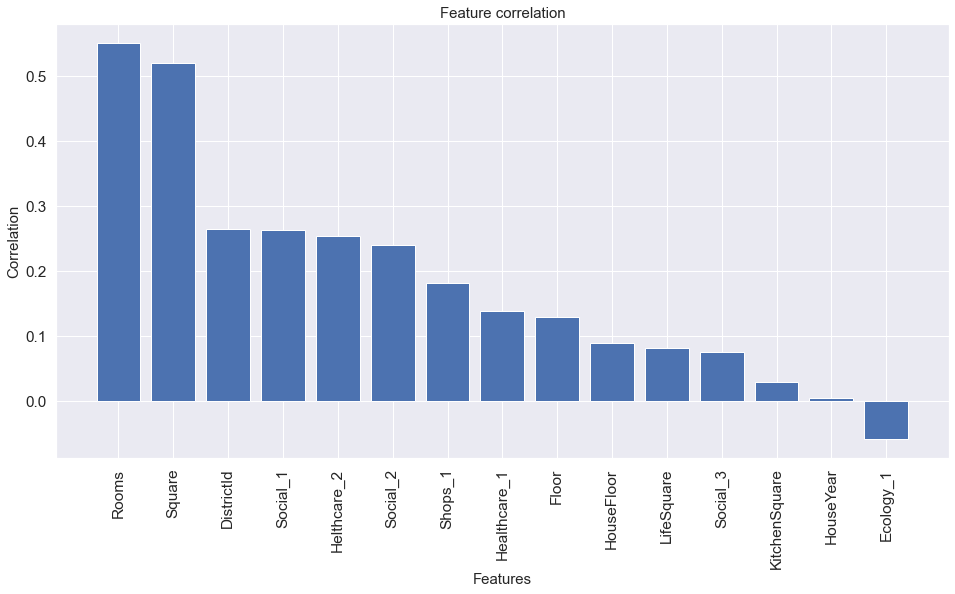

In [142]:
#Кореляция признаков до обработки
def feature_corr():
    correlation = df_train.corrwith(df_train['Price']).sort_values(ascending=False)
    correlation.drop('Price', inplace=True)

    plt.figure(figsize = (16, 8))
    plt.bar(correlation.index, correlation)
    plt.xticks(rotation='90')
    plt.xlabel('Features', fontsize=15)
    plt.ylabel('Correlation', fontsize=15)
    plt.title('Feature correlation', fontsize=15)
    plt.show()

feature_corr()

### EDA  <a class='anchor' id='eda'>


**Целевая переменная**

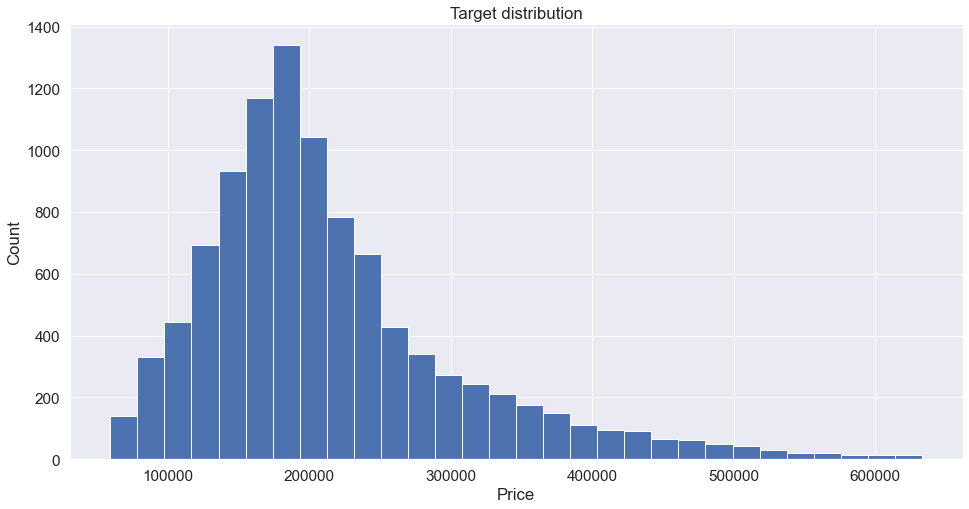

In [143]:
plt.figure(figsize = (16, 8))

df_train['Price'].hist(bins=30)
plt.ylabel('Count')
plt.xlabel('Price')

plt.title('Target distribution')
plt.show()

**Корреляция признаков и целевой переменной**

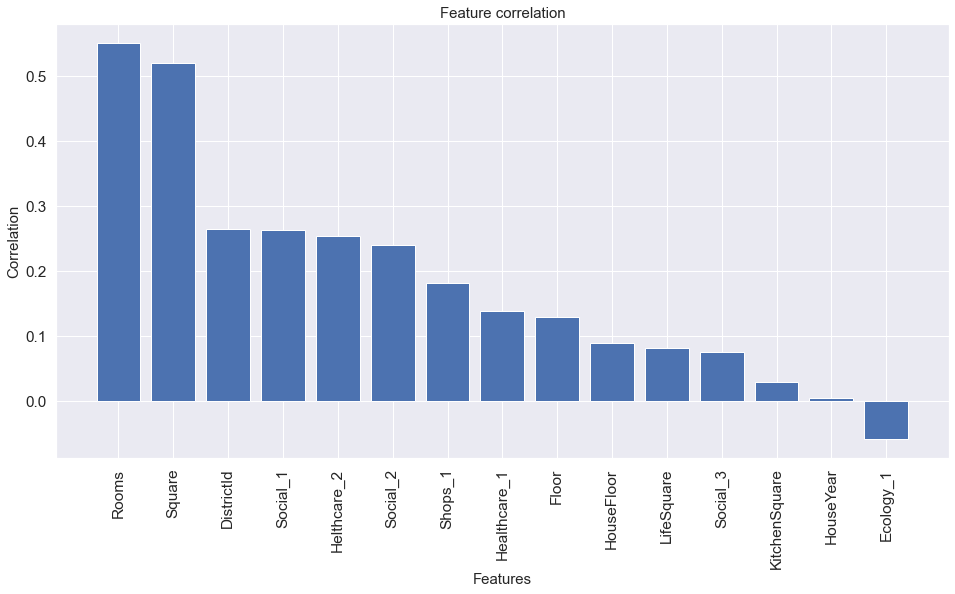

In [144]:
correlation = df_train.corrwith(df_train['Price']).sort_values(ascending=False)
correlation.drop('Price', inplace=True)

plt.figure(figsize = (16, 8))
plt.bar(correlation.index, correlation)
plt.xticks(rotation='90')
plt.xlabel('Features', fontsize=15)
plt.ylabel('Correlation', fontsize=15)
plt.title('Feature correlation', fontsize=15)
plt.show()

#### **Количественные переменные**

In [145]:
round(df_train.describe(include = 'all'),2)

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
count,10000,10000.00,10000.00,10000.00,7887.00,10000.00,10000.00,10000.00,10000.00,10000.00,10000,10000,10000.00,10000.00,10000.00,5202.00,10000.00,10000.00,10000,10000.00
unique,10000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,2,NaN,NaN,NaN,NaN,NaN,NaN,2,NaN
top,11809,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,B,B,NaN,NaN,NaN,NaN,NaN,NaN,B,NaN
freq,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9903,9725,NaN,NaN,NaN,NaN,NaN,NaN,9175,NaN
mean,NaN,50.40,1.89,56.32,37.20,6.27,8.53,12.61,3990.17,0.12,NaN,NaN,24.69,5352.16,8.04,1142.90,1.32,4.23,NaN,214138.86
std,NaN,43.59,0.84,21.06,86.24,28.56,5.24,6.78,200500.26,0.12,NaN,NaN,17.53,4006.80,23.83,1021.52,1.49,4.81,NaN,92872.29
min,NaN,0.00,0.00,1.14,0.37,0.00,1.00,0.00,1910.00,0.00,NaN,NaN,0.00,168.00,0.00,0.00,0.00,0.00,NaN,59174.78
25%,NaN,20.00,1.00,41.77,22.77,1.00,4.00,9.00,1974.00,0.02,NaN,NaN,6.00,1564.00,0.00,350.00,0.00,1.00,NaN,153872.63
50%,NaN,36.00,2.00,52.51,32.78,6.00,7.00,13.00,1977.00,0.08,NaN,NaN,25.00,5285.00,2.00,900.00,1.00,3.00,NaN,192269.64
75%,NaN,75.00,2.00,65.90,45.13,9.00,12.00,17.00,2001.00,0.20,NaN,NaN,36.00,7227.00,5.00,1548.00,2.00,6.00,NaN,249135.46


In [146]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             10000 non-null  object 
 1   DistrictId     10000 non-null  int64  
 2   Rooms          10000 non-null  float64
 3   Square         10000 non-null  float64
 4   LifeSquare     7887 non-null   float64
 5   KitchenSquare  10000 non-null  float64
 6   Floor          10000 non-null  int64  
 7   HouseFloor     10000 non-null  float64
 8   HouseYear      10000 non-null  int64  
 9   Ecology_1      10000 non-null  float64
 10  Ecology_2      10000 non-null  object 
 11  Ecology_3      10000 non-null  object 
 12  Social_1       10000 non-null  int64  
 13  Social_2       10000 non-null  int64  
 14  Social_3       10000 non-null  int64  
 15  Healthcare_1   5202 non-null   float64
 16  Helthcare_2    10000 non-null  int64  
 17  Shops_1        10000 non-null  int64  
 18  Shops_2

**Номинативные переменные**

In [147]:
df_train.select_dtypes(include='object').columns.tolist()

['Id', 'Ecology_2', 'Ecology_3', 'Shops_2']

In [148]:
df_train['DistrictId'].value_counts().sort_index()

0       48
1      652
2       78
3       82
4       11
      ... 
202      2
205      1
207      1
208      2
209      1
Name: DistrictId, Length: 205, dtype: int64

In [149]:
df_train['Ecology_2'].value_counts()

B    9903
A      97
Name: Ecology_2, dtype: int64

In [150]:
df_train['Ecology_3'].value_counts()

B    9725
A     275
Name: Ecology_3, dtype: int64

In [151]:
df_train['Shops_2'].value_counts()

B    9175
A     825
Name: Shops_2, dtype: int64

### Зависимость целевой переменной от признаков

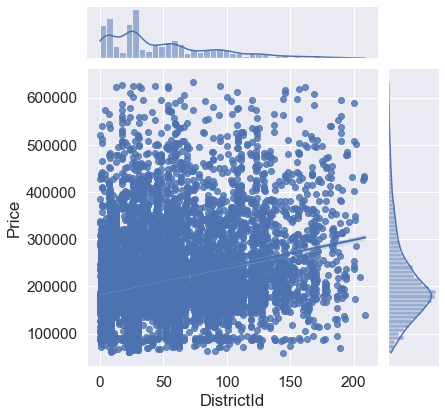

In [152]:
grid=sns.jointplot(df_train['DistrictId'], df_train['Price'], kind='reg')
grid.fig.set_figwidth(6)
grid.fig.set_figheight(6)

plt.show()

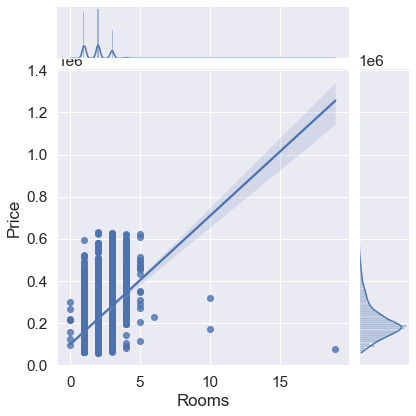

In [153]:
grid = sns.jointplot(df_train['Rooms'], df_train['Price'], kind='reg')
grid.fig.set_figwidth(6)
grid.fig.set_figheight(6)

plt.show()

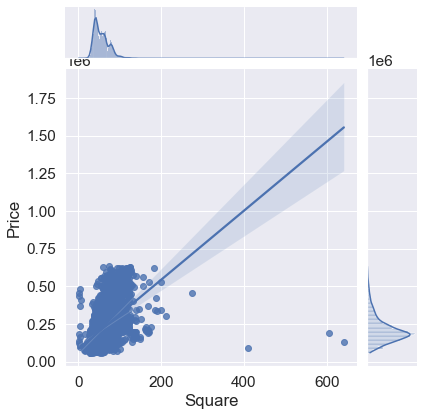

In [154]:
grid = sns.jointplot(df_train['Square'], df_train['Price'], kind='reg')
grid.fig.set_figwidth(6)
grid.fig.set_figheight(6)

plt.show()

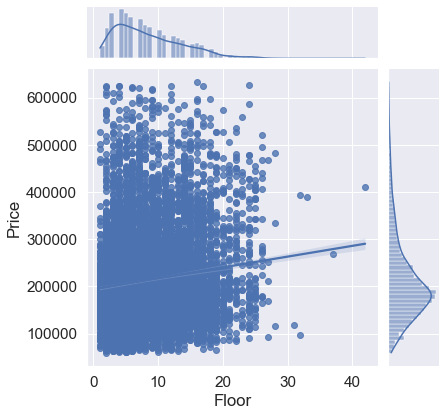

In [155]:
grid = sns.jointplot(df_train['Floor'], df_train['Price'], kind='reg')
grid.fig.set_figwidth(6)
grid.fig.set_figheight(6)

plt.show()

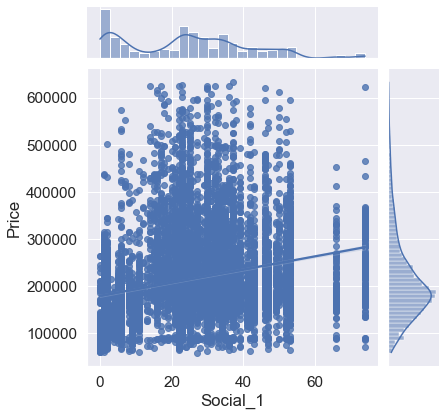

In [156]:
grid = sns.jointplot(df_train['Social_1'], df_train['Price'], kind='reg')
grid.fig.set_figwidth(6)
grid.fig.set_figheight(6)

plt.show()

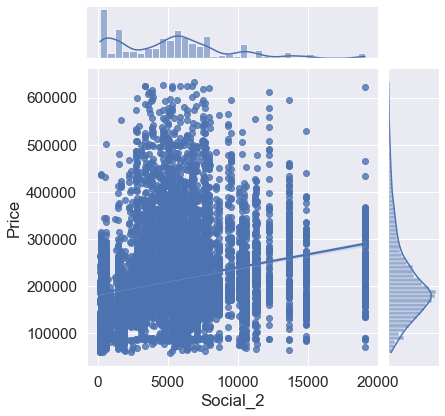

In [157]:
grid = sns.jointplot(df_train['Social_2'], df_train['Price'], kind='reg')
grid.fig.set_figwidth(6)
grid.fig.set_figheight(6)

plt.show()

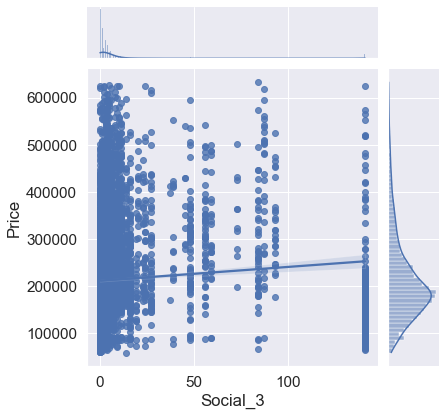

In [158]:
grid = sns.jointplot(df_train['Social_3'], df_train['Price'], kind='reg')
grid.fig.set_figwidth(6)
grid.fig.set_figheight(6)

plt.show()

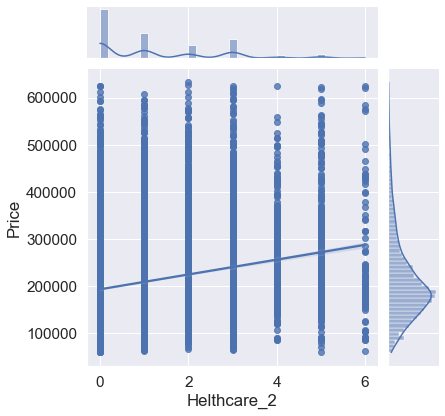

In [159]:
grid = sns.jointplot(df_train['Helthcare_2'], df_train['Price'], kind='reg')
grid.fig.set_figwidth(6)
grid.fig.set_figheight(6)

plt.show()

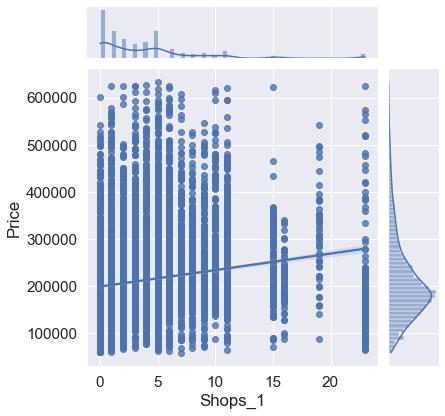

In [160]:
grid = sns.jointplot(df_train['Shops_1'], df_train['Price'], kind='reg')
grid.fig.set_figwidth(6)
grid.fig.set_figheight(6)

plt.show()

#### Матрица корреляций

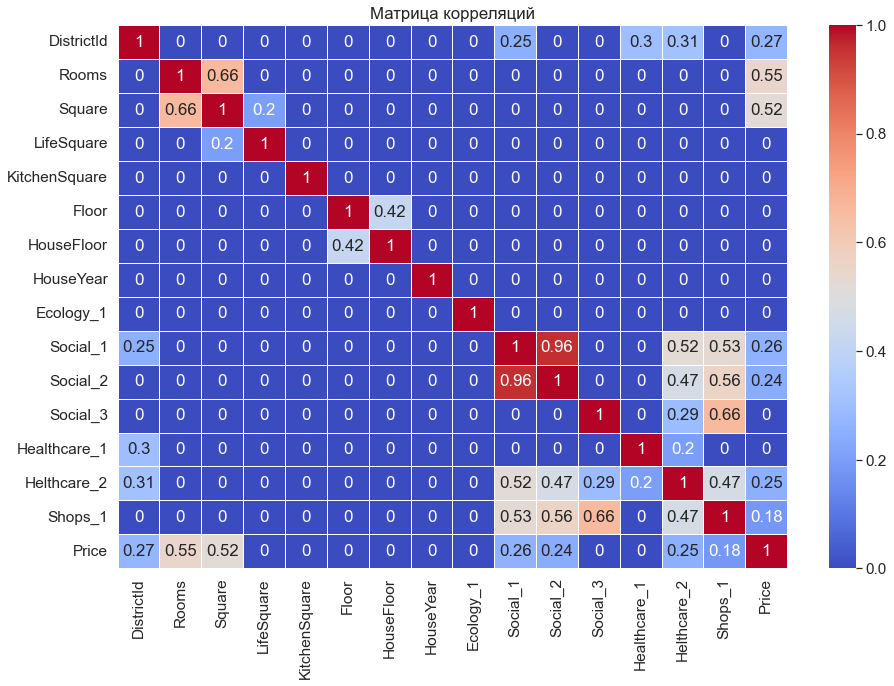

In [161]:
plt.figure(figsize = (15,10))

sns.set(font_scale=1.4)

corr_matrix = df_train.corr()
corr_matrix = np.round(corr_matrix, 2)
corr_matrix[np.abs(corr_matrix) < 0.18] = 0

sns.heatmap(corr_matrix, annot=True, linewidths=.5, cmap='coolwarm')

plt.title('Матрица корреляций')
plt.show()

### Обработка выбросов  <a class='anchor' id='outlier'>


**Rooms**

In [162]:
df_train['Rooms'].value_counts().sort_index()

0.0        8
1.0     3705
2.0     3880
3.0     2235
4.0      150
5.0       18
6.0        1
10.0       2
19.0       1
Name: Rooms, dtype: int64

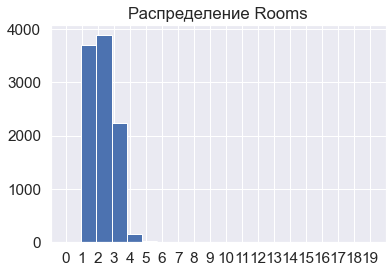

In [163]:
plt.xticks(np.arange(0,20,1))
#sns.distplot(df_train['Rooms'])
df_train['Rooms'].hist(bins=20)
plt.title('Распределение Rooms')
plt.show()

In [164]:
df_train.loc[df_train['Rooms'] == 0, 'Rooms'] = 1
df_train.loc[df_train['Rooms'] >= 6, 'Rooms'] = 5

In [165]:
df_train['Rooms'].value_counts()

2.0    3880
1.0    3713
3.0    2235
4.0     150
5.0      22
Name: Rooms, dtype: int64

**Square**

In [166]:
df_train['Square'].value_counts().sort_index()

1.136859      1
1.988943      1
2.377248      1
2.596351      1
2.954309      1
             ..
212.932361    1
275.645284    1
409.425181    1
604.705972    1
641.065193    1
Name: Square, Length: 10000, dtype: int64

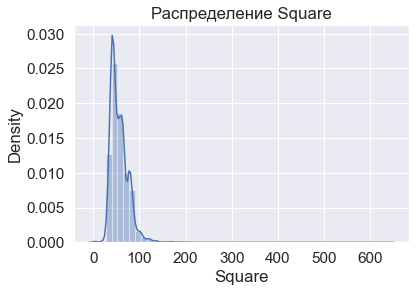

In [167]:
plt.xticks(np.arange(0,650,100))
sns.distplot(df_train['Square'])
plt.title('Распределение Square')
plt.show()

In [168]:
df_train.loc[df_train['Square'] <= 15, 'Square'] = 15
df_train.loc[df_train['Square'] >= 250, 'Square'] = 250

In [169]:
df_train['Square'].value_counts().sort_index()

15.000000     13
16.117154      1
16.547242      1
17.046188      1
17.414181      1
              ..
190.857689     1
198.930182     1
200.334539     1
212.932361     1
250.000000     4
Name: Square, Length: 9985, dtype: int64

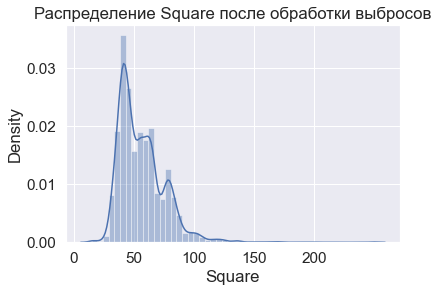

In [170]:
plt.xticks(np.arange(0,250,50))
sns.distplot(df_train['Square'])
plt.title('Распределение Square после обработки выбросов')
plt.show()

**KitchenSquare** 

In [171]:
df_train['KitchenSquare'].value_counts().sort_index()

0.0        697
1.0       2460
2.0          4
3.0         22
4.0         39
5.0       1169
6.0       1038
7.0        609
8.0       1306
9.0        843
10.0      1075
11.0       233
12.0       249
13.0        67
14.0        51
15.0        31
16.0        16
17.0        12
18.0         6
19.0        11
20.0        14
21.0         1
22.0         3
23.0         1
25.0         2
26.0         1
27.0         1
29.0         1
30.0         2
31.0         1
32.0         2
35.0         1
36.0         1
37.0         2
39.0         1
40.0         1
41.0         2
42.0         1
43.0         2
48.0         1
51.0         2
53.0         1
54.0         1
58.0         2
60.0         1
62.0         1
63.0         1
66.0         1
72.0         1
73.0         1
75.0         1
78.0         1
84.0         1
96.0         1
112.0        2
123.0        1
1970.0       1
2014.0       1
Name: KitchenSquare, dtype: int64

In [172]:
condition = ((df_train['KitchenSquare'] < 3) | (df_train['KitchenSquare'] > 20))  
df_train.loc[condition, 'KitchenSquare'] = df_train['KitchenSquare'].median()

In [173]:
df_train['KitchenSquare'].value_counts().sort_index()

3.0       22
4.0       39
5.0     1169
6.0     4247
7.0      609
8.0     1306
9.0      843
10.0    1075
11.0     233
12.0     249
13.0      67
14.0      51
15.0      31
16.0      16
17.0      12
18.0       6
19.0      11
20.0      14
Name: KitchenSquare, dtype: int64

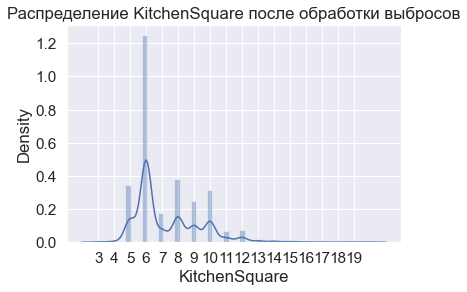

In [174]:
plt.xticks(np.arange(3,20,1))
sns.distplot(df_train['KitchenSquare'])
plt.title('Распределение KitchenSquare после обработки выбросов')
plt.show()

**HouseFloor, Floor**

In [175]:
df_train['HouseFloor'].sort_values().unique()

array([  0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,
        11.,  12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,
        22.,  23.,  24.,  25.,  26.,  27.,  28.,  29.,  30.,  31.,  32.,
        36.,  37.,  38.,  39.,  40.,  44.,  45.,  47.,  48.,  99., 117.])

In [176]:
df_train['Floor'].sort_values().unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 31, 32, 33, 37, 42],
      dtype=int64)

In [177]:
(df_train['Floor'] > df_train['HouseFloor']).sum()

1825

In [181]:
condition_hf = (df_train['HouseFloor'] < df_train['Floor'])
df_train.loc[(df_train['HouseFloor'] == 0) | (df_train['HouseFloor'] > 50), 'HouseFloor'] = df_train['HouseFloor'].median()
df_train.loc[condition_hf, ['HouseFloor', 'Floor']] = (df_train.loc[condition_hf, ['Floor', 'HouseFloor']].values)

In [182]:
(df_train['Floor'] > df_train['HouseFloor']).sum()

0

In [183]:
df_train['HouseFloor'].sort_values().unique()

array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13.,
       14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25., 26.,
       27., 28., 29., 30., 31., 32., 36., 37., 38., 39., 40., 44., 45.,
       47., 48.])

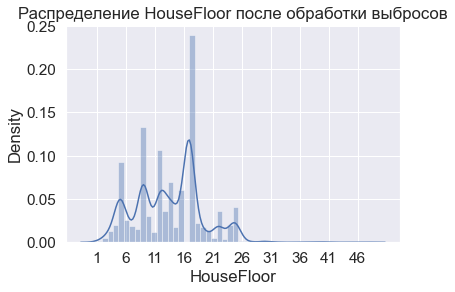

In [184]:
plt.xticks(np.arange(1,50,5))
sns.distplot(df_train['HouseFloor'])
plt.title('Распределение HouseFloor после обработки выбросов')
plt.show()

In [185]:
df_train['Floor'].sort_values().unique()

array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13.,
       14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25., 26.,
       28., 31., 32., 33., 37., 42.])

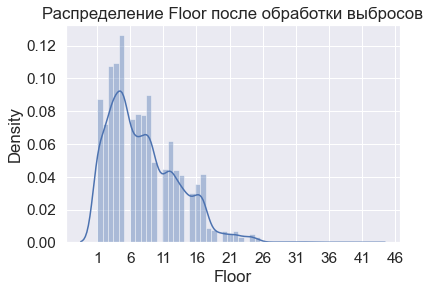

In [186]:
plt.xticks(np.arange(1,50,5))
sns.distplot(df_train['Floor'])
plt.title('Распределение Floor после обработки выбросов')
plt.show()

In [187]:
(df_train['Floor'] > df_train['HouseFloor']).sum()

0

**HouseYear**

In [188]:
df_train['HouseYear'].value_counts().sort_index(ascending=False)

20052011      1
4968          1
2020         19
2019         79
2018        175
           ... 
1917          3
1916          1
1914          1
1912          2
1910          1
Name: HouseYear, Length: 97, dtype: int64

In [189]:
df_train.loc[df_train['HouseYear'] == 20052011, 'HouseYear'] = 2011
df_train.loc[df_train['HouseYear'] == 4968, 'HouseYear'] = 1968
df_train['HouseYear'].value_counts().sort_index()

1910      1
1912      2
1914      1
1916      1
1917      3
       ... 
2016    305
2017    308
2018    175
2019     79
2020     19
Name: HouseYear, Length: 95, dtype: int64

###  Обработка пропусков  <a class='anchor' id='nan'>

In [190]:
df_train.isna().sum()

Id                  0
DistrictId          0
Rooms               0
Square              0
LifeSquare       2113
KitchenSquare       0
Floor               0
HouseFloor          0
HouseYear           0
Ecology_1           0
Ecology_2           0
Ecology_3           0
Social_1            0
Social_2            0
Social_3            0
Healthcare_1     4798
Helthcare_2         0
Shops_1             0
Shops_2             0
Price               0
dtype: int64

In [191]:
df_train['LifeSquare'].value_counts().sort_index()

0.370619       1
0.641822       1
0.795539       1
0.873147       1
1.049867       1
              ..
263.542020     1
410.639749     1
461.463614     1
638.163193     1
7480.592129    1
Name: LifeSquare, Length: 7887, dtype: int64

**LifeSquare**

In [192]:
df_train['LifeSquare'].fillna(((df_train['Square'] - df_train['KitchenSquare']) - df_train['Square']*0.1), inplace=True)

In [193]:
df_train['Square'].value_counts().sort_index()

15.000000     13
16.117154      1
16.547242      1
17.046188      1
17.414181      1
              ..
190.857689     1
198.930182     1
200.334539     1
212.932361     1
250.000000     4
Name: Square, Length: 9985, dtype: int64

In [194]:
(df_train['LifeSquare'] > df_train['Square']).sum()

476

In [195]:
df_train.loc[df_train['LifeSquare'] < 5, 'LifeSquare'] = 5
df_train.loc[df_train['LifeSquare'] > 200, 'LifeSquare'] =200
condition_ls = (df_train['Square'] < df_train['LifeSquare']) 
df_train.loc[condition_ls, 'LifeSquare'] = df_train.loc[condition_ls, 'Square'] - df_train.loc[condition_ls, 'KitchenSquare']-(df_train.loc[condition_ls, 'Square'] * 0.1)

In [196]:
df_train['LifeSquare'].value_counts().sort_index()

5.000000      162
5.005477        1
5.061446        1
5.066533        1
5.114439        1
             ... 
147.341545      1
153.685835      1
161.155275      1
161.504222      1
200.000000      6
Name: LifeSquare, Length: 9832, dtype: int64

In [197]:
(df_train['LifeSquare'] > df_train['Square']).sum()

0

## Классы подготовки данных

In [261]:
class Data:
    
    def __init__(self):
        
        self.medians = None
        self.DistrictId_value_counts = None
        self.SquareMeterPrice_by_DistrictId = None
        self.Healthcare_1_by_DistrictId = None
        
        self.Square_min = 15
        self.Square_max = 250
        
        self.LifeSquare_min = 5
        self.LifeSquare_max = 200
        
        self.Rooms_min = 1
        self.Rooms_max = 5
        
        self.HouseFloor_min = 1
        self.HouseFloor_max = 50
        
        self.KitchenSquare_min = 3
        self.KitchenSquare_max = 30
        
        self.binary_to_numbers = {'A': 0, 'B': 1}           
            
       
    def fit(self, df_train):
                
        #медианы
        self.medians = df_train.median()
        self.districts_healthcare = df_train.groupby(['DistrictId'])['Healthcare_1'].agg('mean').to_dict()
        
        # подсчет средней цены за м2 по району
        df_train_temp = df_train.loc[((df_train['Square'] > self.Square_min) & (df_train['Square'] < self.Square_max))]
        df_train_temp["SquareMeterPrice"] = df_train_temp["Price"] / df_train_temp["Square"]
        self.SquareMeterPrice_by_DistrictId = df_train_temp.groupby('DistrictId', as_index=False)\
            .agg({'SquareMeterPrice': 'mean'})\
            .rename(columns={'SquareMeterPrice': 'AverageSquareMeterPrice'})
        
        # подсчет среднего значения признака Healthcare_1 по району
        self.Healthcare_1_by_DistrictId = df_train.groupby('DistrictId', as_index=False).agg({'Healthcare_1': 'mean'})\
            .rename(columns={'Healthcare_1': 'AverageHealthcare_1'})
        
        del df_train_temp
        
    
    def transform(self, df_train):
              
        # удаление Id
        df_train.drop('Id', axis=1, inplace=True)
        
        #обработка пропусков:
        df_train['LifeSquare'].fillna(((df_train['Square'] - df_train['KitchenSquare']) - df_train['Square']*0.1), inplace=True)
    
        # Обработка выбросов
        df_train.loc[df_train['Rooms'] < self.Rooms_min, 'Rooms'] = self.medians.Rooms
        df_train.loc[df_train['Rooms'] >= self.Rooms_max, 'Rooms'] = self.Rooms_max
               
        df_train.loc[df_train['Square'] < self.Square_min, 'Square'] = self.Square_min
        df_train.loc[df_train['Square'] > self.Square_max, 'Square'] = self.Square_max
        
        condition = ((df_train['KitchenSquare'] < self.KitchenSquare_min) | (df_train['KitchenSquare'] > self.KitchenSquare_max))
        df_train.loc[condition, 'KitchenSquare'] = df_train['KitchenSquare'].median()
       
        condition_hf = (df_train['HouseFloor'] < df_train['Floor'])
        df_train.loc[(df_train['HouseFloor'] < self.HouseFloor_min) | (df_train['HouseFloor'] > self.HouseFloor_max), 'HouseFloor'] = df_train['HouseFloor'].median()
        df_train.loc[condition_hf, ['HouseFloor', 'Floor']] = (df_train.loc[condition_hf, ['Floor', 'HouseFloor']].values)
    
        df_train.loc[df_train['HouseYear'] == 20052011, 'HouseYear'] = 2011
        df_train.loc[df_train['HouseYear'] == 4968, 'HouseYear'] = 1968
        
        df_train.loc[df_train['LifeSquare'] < self.LifeSquare_min, 'LifeSquare'] = self.LifeSquare_min
        df_train.loc[df_train['LifeSquare'] > self.LifeSquare_min, 'LifeSquare'] = self.LifeSquare_max
        condition_ls = (df_train['Square'] < df_train['LifeSquare']) 
        df_train.loc[condition_ls, 'LifeSquare'] = df_train.loc[condition_ls, 'Square'] - df_train.loc[condition_ls, 'KitchenSquare']-(df_train.loc[condition_ls, 'Square'] * 0.1)
        
        df_train['Ecology_2'] = df_train['Ecology_2'].replace(self.binary_to_numbers)
        df_train['Ecology_3'] = df_train['Ecology_3'].replace(self.binary_to_numbers)
        df_train['Shops_2'] = df_train['Shops_2'].replace(self.binary_to_numbers)
        
        
        df_train.loc[df_train['Healthcare_1'].isna(), 'Healthcare_1'] = df_train['DistrictId'].map(self.districts_healthcare)
        df_train['Healthcare_1'].fillna(self.medians.Healthcare_1, inplace=True)       

        return df_train
    
    def features(self, df_train):
        
        # Social в один показатель
        scaler = RobustScaler()
        pca = PCA(n_components=1, random_state=42)
        social_scaled = pd.DataFrame(scaler.fit_transform(df_train[['Social_1', 'Social_2', 'Social_3']]))
        df_train['Social'] = pca.fit_transform(social_scaled)
        df_train.drop(['Social_1', 'Social_2', 'Social_3'], axis=1, inplace=True)
               
        # добавление признака средней стоимости м2 по району
        df_train = df_train.merge(self.SquareMeterPrice_by_DistrictId, on=["DistrictId"], how='left')
        df_train['AverageSquareMeterPrice'].fillna(df_train['AverageSquareMeterPrice'].median(), inplace=True)
        
        # добавление признака среднего значения Healthcare_1 по району
        df_train = df_train.merge(self.Healthcare_1_by_DistrictId, on=["DistrictId"], how='left')
        df_train['AverageHealthcare_1'].fillna(df_train['AverageHealthcare_1'].median(), inplace=True)
        
        return df_train
   

### Разбиение на train и test  <a class='anchor' id='split'>

In [262]:
df_train = pd.read_csv(TRAIN_DATASET_PATH)
df_test = pd.read_csv(TEST_DATASET_PATH)

In [263]:
df_train.describe().head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
count,10000.00000,10000.000000,10000.000000,10000.000000,7887.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,5202.000000,10000.000000,10000.000000,10000.000000
mean,8383.40770,50.400800,1.890500,56.315775,37.199645,6.273300,8.526700,12.609400,3990.166300,0.118858,24.687000,5352.157400,8.039200,1142.904460,1.319500,4.231300,214138.857399
std,4859.01902,43.587592,0.839512,21.058732,86.241209,28.560917,5.241148,6.775974,200500.261427,0.119025,17.532614,4006.799803,23.831875,1021.517264,1.493601,4.806341,92872.293865
min,0.00000,0.000000,0.000000,1.136859,0.370619,0.000000,1.000000,0.000000,1910.000000,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,59174.778028
25%,4169.50000,20.000000,1.000000,41.774881,22.769832,1.000000,4.000000,9.000000,1974.000000,0.017647,6.000000,1564.000000,0.000000,350.000000,0.000000,1.000000,153872.633942


In [264]:
data = Data()
data.fit(df_train)

df_train = data.transform(df_train)
df_train = data.features(df_train)

df_test = data.transform(df_test)
df_test = data.features(df_test)



In [265]:
X = df_train.drop(columns='Price')
y = df_train['Price']

In [266]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.1, shuffle=True, random_state=21)

In [267]:
X_train.shape, X_valid.shape, df_test.shape
X_train.shape, X_valid.shape, df_test.shape

((9000, 18), (1000, 18), (5000, 18))

In [268]:
df_train.describe()

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,Social,AverageSquareMeterPrice,AverageHealthcare_1
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,1.000000e+04,10000.000000,10000.000000
mean,50.400800,1.889600,56.236371,42.586839,7.348500,8.050100,13.40810,1984.866300,0.118858,0.990300,0.972500,1020.620566,1.319500,4.231300,0.917500,214138.857399,-1.840750e-16,3890.750857,1007.857986
std,43.587592,0.813436,19.381202,17.384334,2.255118,5.212591,5.88211,18.412271,0.119025,0.098015,0.163543,916.041247,1.493601,4.806341,0.275139,92872.293865,4.766687e+00,943.556228,826.608379
min,0.000000,1.000000,15.000000,5.000000,3.000000,1.000000,1.00000,1910.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,59174.778028,-1.620569e+00,2284.108677,0.000000
25%,20.000000,1.000000,41.774881,29.984623,6.000000,4.000000,9.00000,1974.000000,0.017647,1.000000,1.000000,240.000000,0.000000,1.000000,1.000000,153872.633942,-1.606565e+00,3021.675025,389.164179
50%,36.000000,2.000000,52.513310,39.359136,6.000000,7.000000,14.00000,1977.000000,0.075424,1.000000,1.000000,900.000000,1.000000,3.000000,1.000000,192269.644879,-1.210134e+00,4084.464328,832.258065
75%,75.000000,2.000000,65.900625,52.030291,9.000000,12.000000,17.00000,2001.000000,0.195781,1.000000,1.000000,1322.000000,2.000000,6.000000,1.000000,249135.462171,-6.124105e-01,4489.819204,1322.000000
max,209.000000,5.000000,250.000000,200.000000,30.000000,42.000000,48.00000,2020.000000,0.521867,1.000000,1.000000,4849.000000,6.000000,23.000000,1.000000,633233.466570,2.659215e+01,9452.113505,4849.000000


In [269]:
X_train.isna().sum().sum(), X_valid.isna().sum().sum(), df_test.isna().sum().sum()


(0, 0, 0)

### Построение модели  <a class='anchor' id='modeling'>

**Обучение и оценка модели**

Train R2:	0.839
Test R2:	0.771


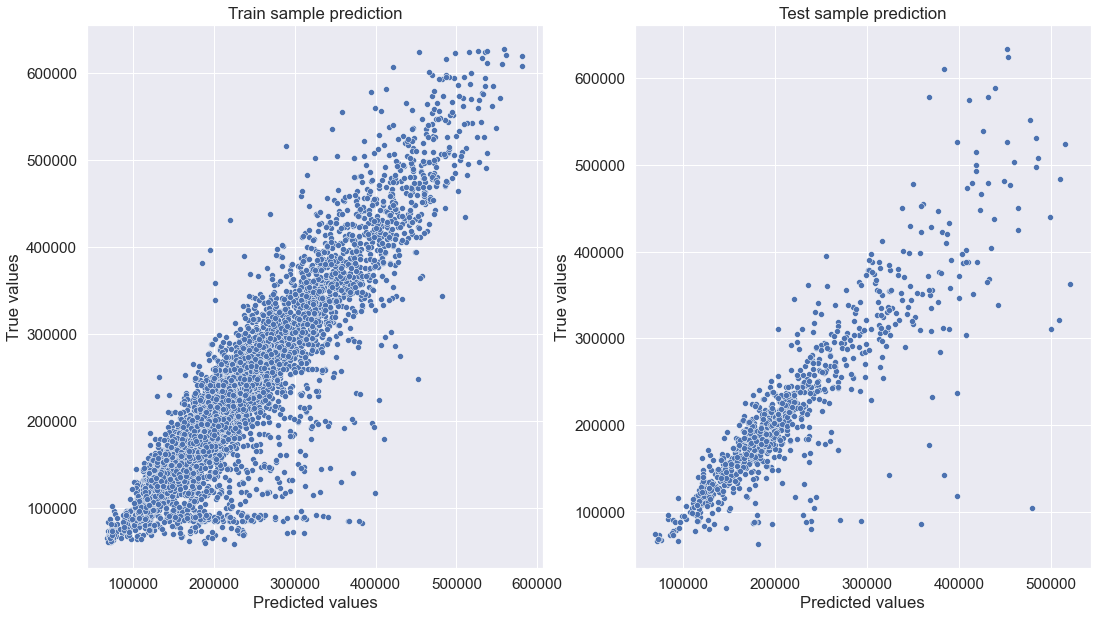

In [270]:
gb_model = GradientBoostingRegressor(criterion='mse',
                                     max_depth=6,
                                     min_samples_leaf=14,
                                     random_state=42,  
                                     n_estimators=50)
                                     

gb_model.fit(X_train, y_train)

y_train_preds = gb_model.predict(X_train)
y_valid_preds = gb_model.predict(X_valid)

y_train_preds = gb_model.predict(X_train)
y_valid_preds = gb_model.predict(X_valid)

evaluate_preds(y_train, y_train_preds, y_valid, y_valid_preds)

**Кросс-валидация**

In [272]:
cv_score = cross_val_score(gb_model, X_train, y_train, scoring='r2', cv=KFold(n_splits=10, shuffle=True, random_state=21))
cv_score

array([0.76334993, 0.75361446, 0.68819647, 0.81496391, 0.75759539,
       0.75784238, 0.74065938, 0.74295374, 0.76407402, 0.78586855])

In [273]:
cv_score.mean()

0.7569118233759544

**Важность признаков**

In [275]:
feature_importances = pd.DataFrame(zip(X_train.columns, gb_model.feature_importances_), 
                                   columns=['feature_name', 'importance'])

feature_importances.sort_values(by='importance', ascending=False)

,feature_name,importance
2,Square,0.455137
16,AverageSquareMeterPrice,0.384364
1,Rooms,0.035099
7,HouseYear,0.022298
15,Social,0.017671
4,KitchenSquare,0.013695
6,HouseFloor,0.012938
3,LifeSquare,0.012111
8,Ecology_1,0.010658
5,Floor,0.008522


### Обучение на всем train

In [276]:
df_train = pd.read_csv(TRAIN_DATASET_PATH)
df_test = pd.read_csv(TEST_DATASET_PATH)

data = Data()
data.fit(df_train)

df_train = data.transform(df_train)
df_train = data.features(df_train)

df_test = data.transform(df_test)
df_test = data.features(df_test)

X = df_train.drop(columns='Price')
y = df_train['Price']

In [277]:
X.isna().sum().sum(), df_test.isna().sum().sum()

(0, 0)

In [278]:
gb_model = GradientBoostingRegressor(criterion='mse',
                                     max_depth=6,
                                     min_samples_leaf=40,
                                     random_state=42,  
                                     n_estimators=60)
                                     
gb_model.fit(X, y)

GradientBoostingRegressor(criterion='mse', max_depth=6, min_samples_leaf=40,
                          n_estimators=60, random_state=42)

### Прогнозирование на тестовом датасете  <a class='anchor' id='prediction'>

In [279]:
df_test.shape

(5000, 18)

In [280]:
df_test.head()

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Social,AverageSquareMeterPrice,AverageHealthcare_1
0,44,1.0,36.847630,28.162867,5.0,5.0,9.0,1970,0.036122,1,1,1036.0,1,1,1,-1.654285,4572.483767,905.979798
1,62,1.0,42.493907,28.244516,10.0,7.0,17.0,2017,0.072158,1,1,2300.0,0,0,0,-1.462656,2818.749357,2300.000000
2,27,2.0,59.463678,44.517310,9.0,19.0,19.0,1977,0.211401,1,1,900.0,0,1,1,-1.659865,2766.023246,832.258065
3,23,3.0,49.646030,38.681427,6.0,2.0,2.0,1965,0.014073,1,1,0.0,0,0,1,-1.662911,2284.108677,0.000000
4,74,1.0,53.837056,42.453350,6.0,8.0,17.0,1977,0.309479,1,1,990.0,0,6,1,-0.847631,3355.343060,832.258065


In [281]:
submit = pd.read_csv('sample_submission.csv')
submit.head()

,Id,Price
0,4567,200000.0
1,5925,200000.0
2,960,200000.0
3,3848,200000.0
4,746,200000.0


In [282]:
predictions = gb_model.predict(df_test)
predictions

array([166255.29880109, 117649.91054677, 124726.16587862, ...,
       145225.17365845, 187277.99582047, 270766.08124846])

In [283]:
submit['Price'] = predictions
submit.head()

,Id,Price
0,4567,166255.298801
1,5925,117649.910547
2,960,124726.165879
3,3848,94558.120742
4,746,173511.841867


In [284]:
submit.shape

(5000, 2)

In [285]:
submit.to_csv('jv_courseproject_submit.csv', index=False)